# ISAE FOTSU321 : Imagerie radar
# BE 2 - 20/11/2018

## LE MOULEC Gauthier

<span style="color:blue"> Instructions générales : </span> 
 * complétez votre nom et prénom dans la cellule ci-dessus
 
 
 * Durée du BE : 2h.
 
 
 * Vous pouvez répondre aux questions qui ne nécessitent pas de code soit directement dans le notebook en convertissant les cellules prévues à cet effet en "Markdown" et en y tapant votre réponse, soit sur une feuille manuscrite que vous n'oublierez pas de me remettre à la fin des 2h (puis de m'envoyer au cours de la semaine lorsque vous aurez terminé). N'hésitez pas à créer des cellules supplémentaires si vous en avez besoin.
 
 
 * Faites attention aux variables "globales", qui sont définies pour tout le notebook ! Si vous en utilisez, donnez leur des noms spécifiques. Attention donc à l'ordre de vos évaluations. Autant que possible, encapsulez vos variables dans des fonctions (variables locales). Je veux pouvoir executer votre notebook dans l'ordre depuis le début et reproduire vous outputs (ce que vous pouvez vérifier vous-mêmes en faisant Kernel "Restart & Clear Output" puis en réévaluant toutes les cellules dans l'ordre).
 
 
 * On se placera pour simplifier dans l'approximation Terre plate et orbite rectiligne (comme dans le cours) : on néglige la rotondité de la Terre et la courbure de l'orbite.

## <span style="color:red"> Contexte et données d'entrée </span>

On considère un radar imageur possédant les caractéristiques suivantes (définies dans la cellule ci-dessous ainsi que la vitesse de la lumière; j'en profite aussi pour importer quelques packages qui vous seront utiles - si vous ne connaissez pas scipy, vous pouvez largement faire sans):
 * vitesse satellite $v=7400$ m/s 
 * altitude $H=900$ km
 * $PRF = 2080$ Hz
 * fréquence d'échantillonnage de l'écho retour $f_s = 200 MHz$
 * fréquence centrale du chirp $f_c=35.75$ GHz
 * bande du chirp $B_{\rm chirp}=200$ MHz
 * durée chirp $\tau = 5.7 \mu s$
 * range au near-range (= début de fauchée = range du premier pixel de chaque ligne) $R_{\rm nr} = 900055.5538$ m
 * longueur de l'antenne (dans la direction de l'orbite) $L = 10$ m
 
 

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from scipy import signal

c = 299792458.

v = 7400.
PRF = 2080.
f_c = 35.75e9
tau = 5.7e-6
f_s = 200.0e6
B_chirp = 200.0e6
H = 900.0e3
R_nr = 900055.5538
L = 10.

Nous allons travailler sur une image (déjà focalisée) de la Seine prise par ce radar. Les données sont contenues dans le fichier 'seine.npy'. Les quelques lignes de code ci-dessous importent les données (de taille N_a x Nr = 4096 x 4096), les stockent dans un tableau nommé full_image puis affichent leur amplitude à l'écran. Pour vous simplifier la vie, je vous définis comme pour le BE1 une fonction de visualisation plot_gray *qui prend en argument un tableau de réels* et qui l'affiche en échelles de gris. Notez que les données d'entrée sont complexes.

Etant donné la taille importante de l'image (4096x4096), il est impossible (à moins que vous ayez tous des écrans 8K...) de l'afficher à l'écran en "pleine résolution" (écran, pas radar...) c'est-à-dire sans que matplotlib n'applique une cuisine interne pour réduire le nombre de pixels à afficher. Pour éviter cela, nous allons définir 4 zones d'intérêt de taille 800x800 dont les caractéristiques sont définies dans la cellule ci-dessous. Ces zones sont labellisées de 1 à 4 de gauche à droite de l'image et sont encadrées en rouge dans l'image ci-dessous. Je vous fournis également une fonction extract_zoom qui renvoie un tableau de taille 800x800 contenant le sous-ensemble de l'image correspondant. La dernière ligne de la cellule montre un exemple d'utilisation de my_plot et de extract_zoom.

Enfin, la fonction plot_binary vous servira à visualiser des données binaires (1 ou 0), typiquement les masques d'eau que vous allez construire au cours du BE.

Taille de l'image : (4096, 4096)


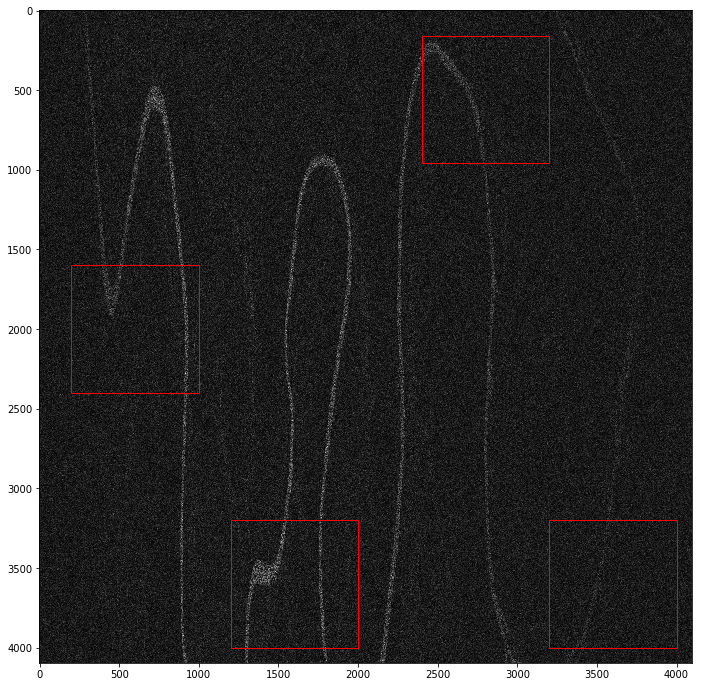

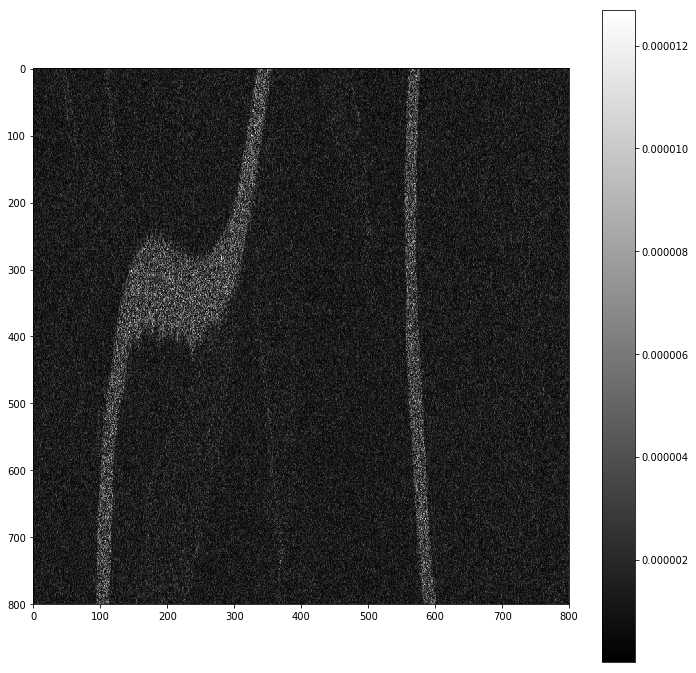

In [79]:
full_image = np.load('seine.npy')
N_a, N_r = full_image.shape
print("Taille de l'image :",  full_image.shape)

def extract_zoom(zoom_i, image):
    window_params = zoom_list[zoom_i]
    i0, delta_i = window_params['line_start'], window_params['nb_lines']
    j0, delta_j = window_params['column_start'], window_params['nb_columns']
    return image[i0:i0+delta_i, j0:j0+delta_j]

def plot_gray(tab):
    plt.figure(figsize=(12,12))
    plt.imshow(tab, cmap='gray')
    plt.colorbar()
    
def plot_binary(tab):
    plt.figure(figsize=(6,6))
    plt.imshow(tab)

zoom_list = {
    1:{'line_start':1600, 'nb_lines':800, 'column_start':200, 'nb_columns':800},
    2:{'line_start':3200, 'nb_lines':800, 'column_start':1200, 'nb_columns':800},
    3:{'line_start':160, 'nb_lines':800, 'column_start':2400, 'nb_columns':800},
    4:{'line_start':3200, 'nb_lines':800, 'column_start':3200, 'nb_columns':800}
}

fig, ax = plt.subplots(1, figsize=(12,12))
ax.imshow(np.abs(full_image), cmap='gray')
for i in zoom_list:
    z = zoom_list[i]
    rect = patches.Rectangle((z['column_start'],z['line_start']),z['nb_lines'],z['nb_columns'],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

plot_gray(np.abs(extract_zoom(2, full_image)))

Notre but dans ce BE est de détecter l'eau dans cette image, c'est-à-dire de construire une image binaire de même taille pour laquelle chaque pixel vaut 1 si le pixel radar correspond à de l'eau et 0 sinon. Nous allons mettre en place une stratégie simplifiée mais qui correspond sur le principe à la façon dont l'eau sera détectée dans la mission SWOT (en mode hydrologie... en mode océan, la détection d'eau est plutôt aisée...). L'idée au coeur de l'algorithme est que l'eau et la terre interagissent très différemment avec l'onde électromagnétique émise par le radar et possèdent donc un $\sigma_0$ très différent. Je vous rappelle que $\sigma_0$ est un nombre sans dimension qui caractérise la rétrodiffusion par unité de surface d'un milieu. Dans notre cas, c'est l'eau qui "domine" la rétrodiffusion. On prendra dans ce BE les hypothèses "moyennes" suivantes
 * $\sigma_0^{\rm eau} = 10 {\rm dB}$
 * $\sigma_0^{\rm terre} = 2 {\rm dB}$

## <span style="color:red"> Partie 1 </span>

<span style="color:blue">Question 0 : </span> De quels paramètres physiques dépend principalement la valeur de $\sigma_0$ ? Notez par exemple que sur la plupart des images radar que nous avons vues en cours, l'eau apparaissait plus foncée que la terre autour. A votre avis, pourquoi est-ce différent ici ?

le surface backscattering dépend principalement de la permittivité diélectrique du sol, de la rugosité de surface ainsi que de la pente locale de la zone étudiée (phénomènes d'ombres éventuiels). Ici, on est en bande Ka (longueur d'onde de l'ordre du cm). Un plan d'eau ou un fleuve se comporte alors comme un miroir à cette fréquence, contrairement aux surfaces continentales environnantes.

<span style="color:blue">Question 1 : </span> Définissez trois tableaux 1D de taille N_r appelés R_k, rho_k et theta_k contenant respectivement les valeurs de
* range de chaque pixel
* distance au sol entre la trace du satellite et chaque pixel (distance cross-track) 
* angles de vue pour chaque pixel

le long d'une ligne de l'image.

In [80]:
H = 900.0e3
R_nr = 900055.5538
f_s = 200.0e6
rho_0 = np.sqrt(R_nr**2-H**2)

R_k = np.linspace(R_nr,R_nr+(N_r)*(c/2/f_s),N_r)
rho_k = np.sqrt(R_k**2-H**2)
theta_k = np.arcsin(rho_k/R_k)

<span style="color:blue">Question 2 : </span> Calculez la taille au sol des zones d'intérêt

La taille au sol est d'environ 800*800 pixels. Mais la taille au sol des pixels dépend du range...

In [81]:
v = 7400
PRF =2080
l_rg = np.arange(4)
l_rg[0] = rho_k[1000] - rho_k[200]
l_rg[1] = rho_k[2000] - rho_k[1200]
l_rg[2] = rho_k[3200] - rho_k[2400]
l_rg[3] = rho_k[4000] - rho_k[3200]
#la largeur (taille direction azimuth est elle constante)
l_az = 800*v/PRF
print("l_rgs = [", l_rg[0], l_rg[1], l_rg[2], l_rg[3], "]", "\nl_az = ", l_az)

l_rgs = [ 18846 11451 8703 7694 ] 
l_az =  2846.153846153846


<span style="color:blue">Question 3 : </span> Les deux images que je vous ai affichées plus haut sont des images en amplitude, c'est-à-dire que j'ai pris le module de la donnée radar complexe. Définissez un tableau full_power_image contenant les données radar converties en puissance puis à l'aide de la fonction plot_gray, affichez l'image en puissance.

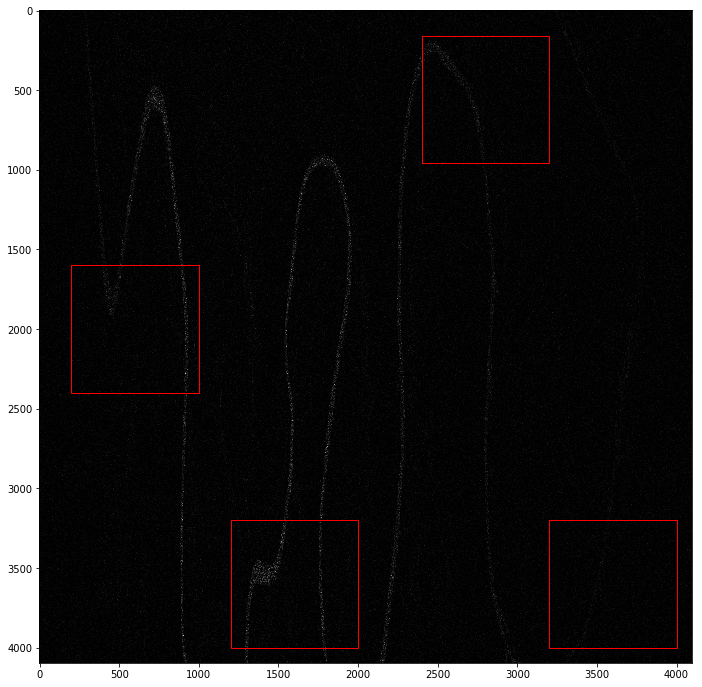

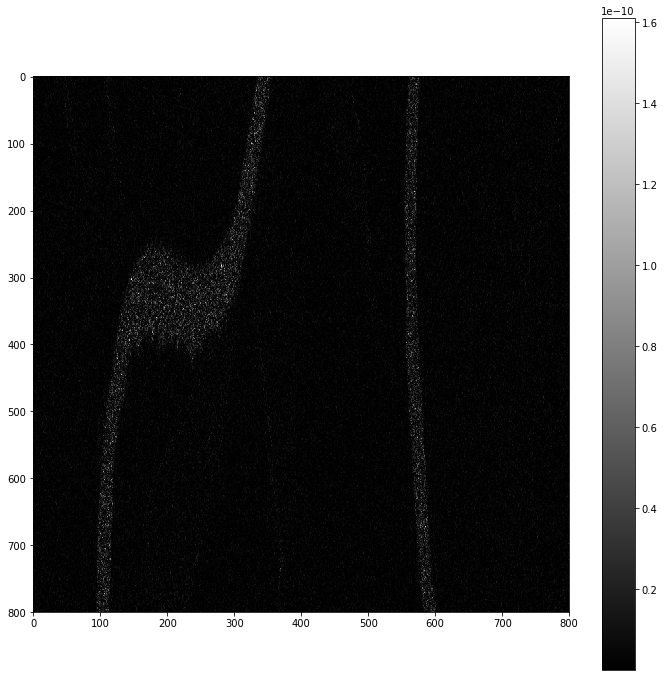

In [82]:
full_power_image = np.abs(full_image)**2

fig, ax = plt.subplots(1, figsize=(12,12))
ax.imshow(np.abs(full_power_image), cmap='gray')
for i in zoom_list:
    z = zoom_list[i]
    rect = patches.Rectangle((z['column_start'],z['line_start']),z['nb_lines'],z['nb_columns'],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

plot_gray(np.abs(extract_zoom(2, full_power_image)))

## <span style="color:red"> Partie 2 </span>

Notre première tâche est de convertir cette image de puissance en image de sigma_0. Nous avons étudié à l'occasion des cours 1 et 3 le "bilan de liaison" d'un radar imageur, c'est-à-dire l'expression de la puissance en fonction des caractéristiques de l'instrument, de la surface (son $\sigma_0$) et du range. Telles que nous les avons écrites, ces formules nous permettaient d'exprimer la puissance de l'image avant focalisation. Je vous donne ci-dessous la formule équivalente pour le cas après processing. La puissance $P$ pour un pixel donnée de l'image est donnée par

$$P = P_e \frac{\lambda^2}{(4\pi)^3} \frac{G_{\rm ant}^2}{R^4}\frac{1}{L_{\rm loss}}({\rm surface\, cellule\, resolution})\, \sigma_0$$ 

où
 * $P_e = 1500$ W est la puissance émise par l'instrument 
 * $G_{\rm ant}$ est le gain d'antenne dans la direction du pixel en question au moment où le radar passe à zéro-Doppler de ce pixel [Note: en réalité, le gain à utiliser ici est le produit du gain d'antenne et du gain de compression dû au processing; pour simplifier, nous allons tout incorporer dans ce gain unique (dont la valeur que je vous donne n'est donc pas réaliste pour un simple gain antenne...)]
 * $R$ est le range du pixel en question
 * $L_{\rm loss}$ est un terme sans dimension de pertes qu'on prendra égal à $8.45$ dB
 * la surface de la cellule de résolution sera calculée, comme en cours, en considérant que cette cellule est rectangulaire et que la réponse impulsionnelle de l'instrument est une fonction porte plutôt qu'un sinus cardinal, c'est-à-dire que *la surface est simplement le produit de la résolution en azimuth et de la résolution range projetée au sol correspondant au pixel en question.*

<span style="color:blue">Question 4 : </span> Expliquez en une phrase pourquoi le range $R$ apparait à la puissance 4 dans cette équation. Et pourquoi le gain d'antenne apparait au carré.

il s'agit d'onde sphérique (puissance à une distance R proportionnelle à 1/R^2) Etant donné qu'on considère un aller retour, il y a donc un facteur 1/R^4. Le gain d'antenne apparait au carré car on a le même phénomène: la puissance est multipliée par le gain d'antenne d'émission et le gain d'antenne de réception. Considérant les deux égaux, on obtient un carré

<span style="color:blue">Question 5 : </span> Expliquez pourquoi on peut considérer que le range $R$ est constant dans cette équation. En considérant que l'antenne est idéale et couvre l'ensemble de la fauchée avec un gain uniforme et égal à $G_{\rm ant} = 75.22 dB$, construisez un tableau 1D contenant le coefficient de proportionalité entre $P$ et $\sigma_0$ (le coefficient par lequel il faut diviser la puissance pour obtenir le $\sigma_0$) en fonction de l'indice de colonne. [Pourquoi ce coefficient dépend-il de l'indice de colonne et pas de l'indice de ligne ?]

Ce qui nous intéresse ici est le facteur en 1/R^4; or, celui-ci ne varie quasiment pas selon la position de la fauchée observée. On peut donc considérer R constant.
On a:
$$P = P_e \frac{\lambda^2}{(4\pi)^3} \frac{G_{\rm ant}^2}{R^4}\frac{1}{L_{\rm loss}}({\rm surface\, cellule\, resolution})\, \sigma_0$$ 
Or, 
$${\rm surface\, cellule\, resolution} = \frac{L}{2} \frac{c}{2.B_{chirp} . sin(\theta)} $$
Donc: 
$$\frac{P}{\sigma_0} = Pe \frac{\lambda^2.G_{ant}^2.L.c}{(4 \pi)^3.4.R^4.L_{loss} . B_{chirp} . sin(\theta)}$$

In [83]:
Pe = 1500 
f_c = 35.75e9
tau = 5.7e-6
L = 10.
L_loss = 10**(5.54/10)
Gant = 10**(75.22/10)

lamb = c/f_c

coeff = Pe*(lamb**2 * Gant**2 * L * c)/(256 * L_loss * R_k**4 * np.pi**3 * B_chirp * np.sin(theta_k))

Ce coefficient varie selon le numero de la colonne du fait de sa dépendance écrite à la ligne ci-dessus; mais est invariant selon la ligne car la taille azimutale d'un pixel est constante.

<span style="color:blue">Question 6 : </span> En divisant ligne par ligne l'image de puissance par le tableau obtenu à la question précédente, construisez une image de $\sigma_0$ que vous appellerez full_sigma0_image et affichez-la à l'aide de plot_gray.

In [84]:
full_sigma0_image = np.ones((N_a,N_r));

for i in range(0,N_a):
        full_sigma0_image[i,:] = full_power_image[i,:]/coeff[i]

<span style="color:blue">Question 7 : </span> Pour construire notre masque d'eau (image binaire eau/terre), nous allons dans un premier temps tout simplement utiliser un seuil sur le $\sigma_0$ : tous les pixels au dessus du seuil seront considérés comme de l'eau tandis que tous les pixels en dessous seront considérés comme de la terre. Avec les hypothèses de $\sigma_0$ que nous avons considérées plus haut, il semble raisonnable de considérer la valeur médiane $\sigma_0^{\rm seuil} = 6$ dB. Construisez le masque d'eau (appelez-le water_mask) sur l'image totale et affichez-le à l'aide de la fonction plot_binary. Affichez également les masques correspondant à chacune des zones d'intérêt. Commentez les résultats. Quelle est la raison pour laquelle notre première approche simpliste donne ces résultats.

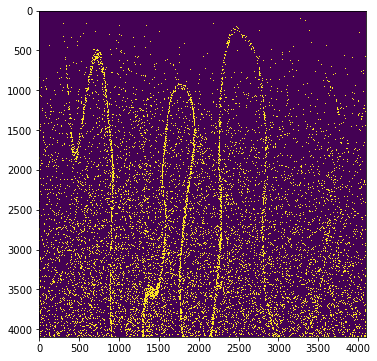

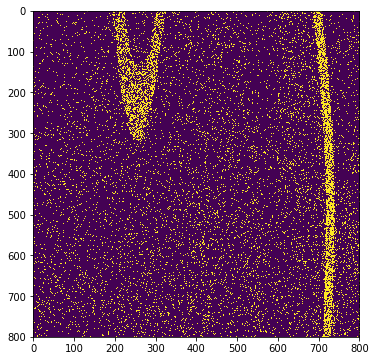

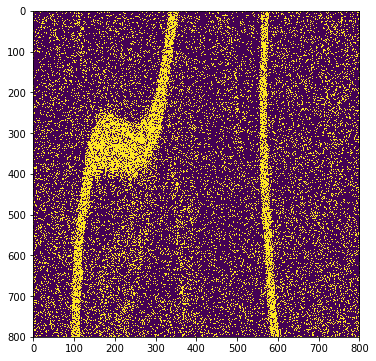

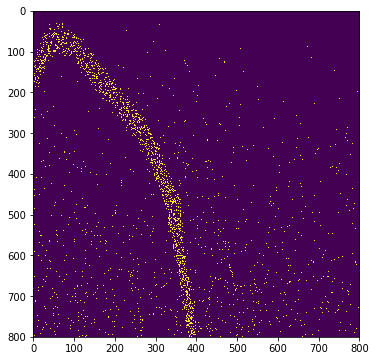

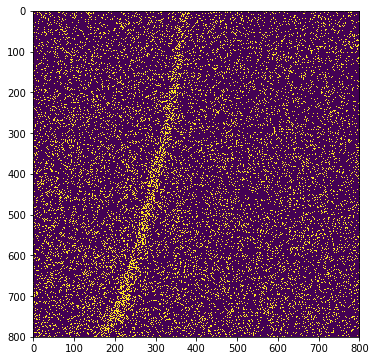

In [85]:
sigma0_seuil = 10**(6/10)

water_mask = full_sigma0_image>sigma0_seuil;

plot_binary(water_mask)

for k in range(1,5): 
    plot_binary(np.abs(extract_zoom(k, water_mask)))

On se rend compte que le dépassement du $\sigma_0$ seuil se fait un peu partout, en particulier sur le bas de l'image, bien qu'on distingue la Seine malgré tout. Ceci est dû à l'image qu'on regarde: en effet, il est possible que les surfaces continentales à côté de la Seine aient localement un $\sigma_0$ élevé, d'autant plus qu'à proximité de la Seine, la terre est probablement humide. D'où cette représentation granulaire... En développant le modèle on va pouvoir supprimer cette granularité en moyennant (en fait, moyenner revient à appliquer un filtre passe-bas).

<span style="color:blue">Question 8 : </span> Les deux quantités $P$ et $\sigma_0$ étant proportionnelles, pourquoi ne pas avoir directement seuillé sur $P$ ?

En réalité, le terme "proportionnel" est trompeur puisque le coefficient de proportionnalité calculé à la question 5 dépend de la projection au sol du pixel!
Ainsi, en seuillant sur $\sigma_0$, on s'affranchit de la parallaxe! On juge directement des propriétés réflexives du sol. 

## <span style="color:red"> Partie 3 </span>

<span style="color:blue">Question 9 : </span> Nous avons vu en cours qu'une façon de remédier à ce problème est de réaliser un moyennage spatial. Expliquez quel est le désavantage d'une telle approche. Nous avons également vu (très rapidement) plusieurs façons (plus ou moins complexes et astucieuses) d'effectuer un tel moyennage. Ici, nous allons utiliser une approche très simple, à savoir un moyennage de l'image de puissance via une fenêtre glissante de taille 7x7. Définissez un tableau full_power_image_multilook de taille (N_a,N_r) qui contient pour chaque pixel la moyenne des puissances des pixels situés dans une fenêtre de taille 7x7 centrée autour du pixel d'origine. Affichez cette image "multilookée".

Le moyennage spatial pousse parfois à une perte d'information au sens où l'on peut avoir l'impression de gommer des singularités de l'image!
De plus, moyenner des images de cette taille peut être très couteux en temps de calcul.

In [ ]:
full_power_image_multilook = np.ones((N_a,N_r));

for i in range(0,3):
     full_power_image_multilook[i,:] = full_power_image[i,:]
        
for i in range(N_a-3,N_a):
     full_power_image_multilook[i,:] = full_power_image[i,:]
        
for j in range(0,3):
     full_power_image_multilook[:,j] = full_power_image[:,j]
        
for j in range(N_r-3,N_r):
     full_power_image_multilook[:,j] = full_power_image[:,j]

for i in range(3,N_a-3):
    for j in range(3,N_r-3):
        full_power_image_multilook[i,j] = np.average(full_power_image[i-3:i+4,j-3:j+4])
        

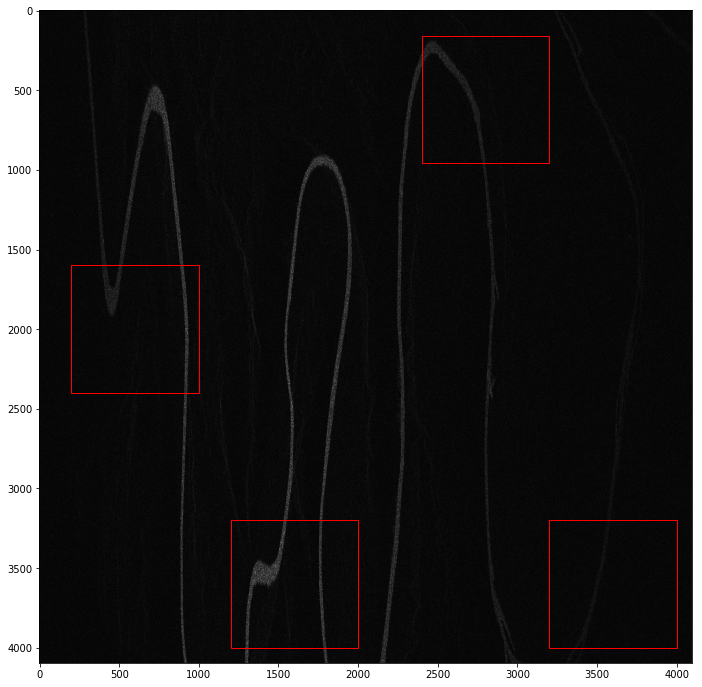

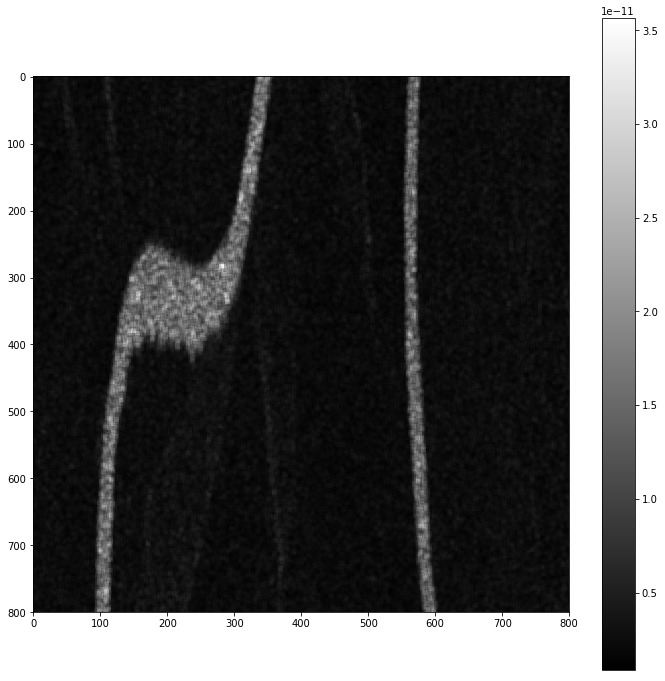

In [65]:
fig, ax = plt.subplots(1, figsize=(12,12))
ax.imshow(np.abs(full_power_image_multilook[0:N_a-1,0:N_r-1]), cmap='gray')
for i in zoom_list:
    z = zoom_list[i]
    rect = patches.Rectangle((z['column_start'],z['line_start']),z['nb_lines'],z['nb_columns'],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

plot_gray(np.abs(extract_zoom(2, full_power_image_multilook)))

<span style="color:blue">Question 10 : </span> A partir de cette image de puissance multilookée, construisez une nouvelle image de $\sigma_0$ full_sigma0_image_multilook puis un nouveau masque d'eau water_mask_multilook (en utilisant toujours le même seuil). Affichez ensuite le masque sur l'image totale et sur les 4 zones d'intérêt. Commentez attentivement les résultats. Quelles parties sont correctement détectées et quelles parties ne le sont pas (faux positifs et faux négatifs...)

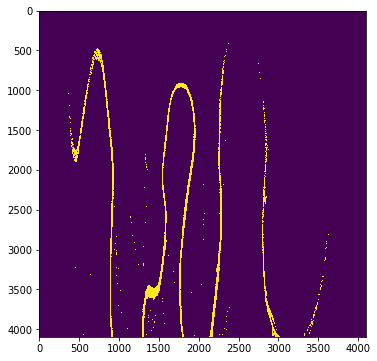

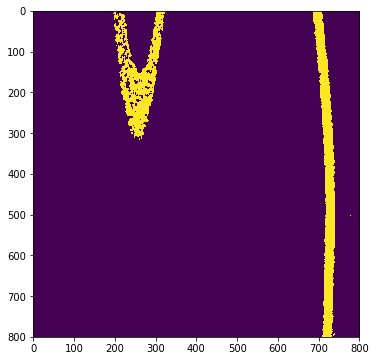

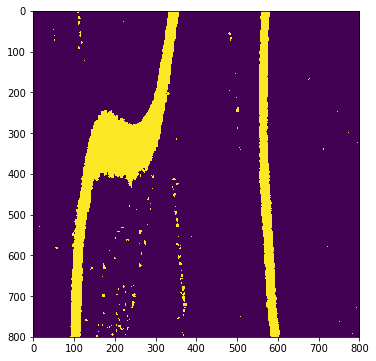

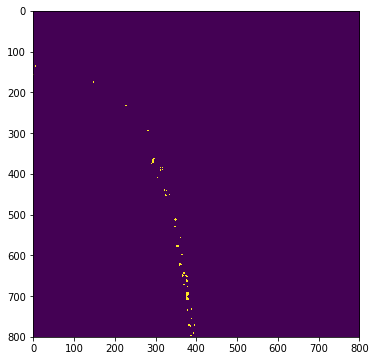

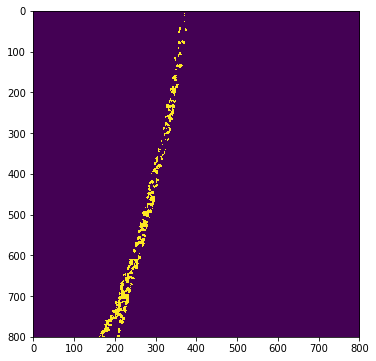

In [67]:
full_sigma0_image_multilook = np.ones((N_a,N_r));

for i in range(0,N_a):
        full_sigma0_image_multilook[i,:] = full_power_image_multilook[i,:]/coeff[i]

water_mask_multilook = full_sigma0_image_multilook>sigma0_seuil;

plot_binary(water_mask_multilook)

for k in range(1,5): 
    plot_binary(np.abs(extract_zoom(k, water_mask_multilook)))

Avec le multilook, on gomme globalement la granularité; cependant, on a encore des zones où le $\sigma_0$ est sur-évalué (zone 2: on a des défauts à proximité du lit de la Seine, on est encore confronté à une légère granularité) et d'autres où il est sous-évalué (zones 3 et 4: on repère difficilement la Seine).
Globalement, on peut aussi noter que les bords droits et gauche de l'image ainsi que le bord haut sont sous évalué (en fait la puissance reçue de ces bords est déjà relativement faible (cf. figure de la question 9).

## <span style="color:red"> Partie 4 </span>

Dans cette dernière partie, nous allons essayer d'améliorer les résultats de la partie précédente en utilisant une description plus fidèle du diagramme d'antenne. En effet, le gain d'antenne n'est pour une antenne réelle pas uniforme dans la fauchée et la valeur que je vous ai fournie plus haut correspond en fait au maximum du gain. Une expression plus réaliste que nous allons utiliser ici est

$$ G_{\rm ant} = G_{\rm max} sinc^2 \left(\alpha\frac{\theta-\theta_c}{\theta_{3dB}}\right)$$

où $\theta$ est l'angle de vue du pixel en question et $\alpha=0.443$, $\theta_c = 3.5°$ et $\theta_{3dB} = 1.24°$ 

<span style="color:blue">Question 11 : </span> Toujours à partir de l'image de puissance multilookée mais en corrigeant la conversion en $\sigma_0$ pour prendre en compte la variation du diagramme d'antenne dans la fauchée, construisez une nouvelle image de $\sigma_0$ full_sigma0_image_multilook_improved puis un nouveau masque d'eau water_mask_multilook_improved (en utilisant toujours le même seuil). Affichez ensuite le masque sur l'image totale et sur les 4 zones d'intérêt. Commentez attentivement les résultats. Quelles parties se sont améliorées et pourquoi ?

In [76]:
alpha = 0.443
theta_c = 3.5*np.pi/180
theta_3dB = 2.48*np.pi/180

coeffReal = np.ones(N_r)

coeffReal = coeff * np.sinc(alpha*(theta_k-theta_c)/theta_3dB)**4 

full_sigma0_image_multilook_improved = np.ones((N_a,N_r));

for i in range(0,N_a):
        full_sigma0_image_multilook_improved[i,:] = full_power_image_multilook[i,:]/coeffReal[i]

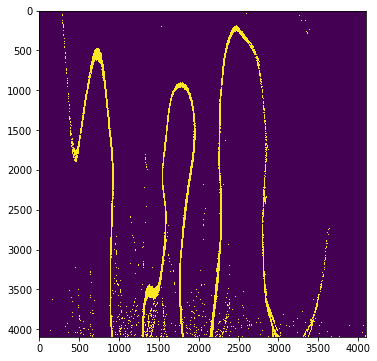

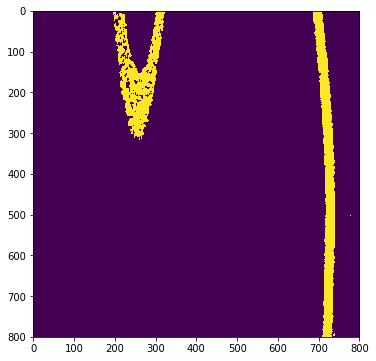

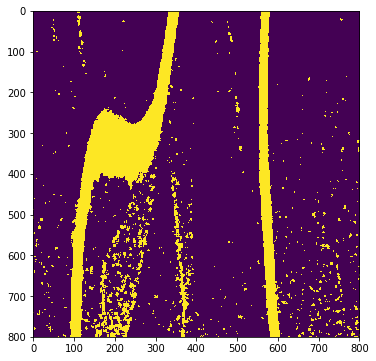

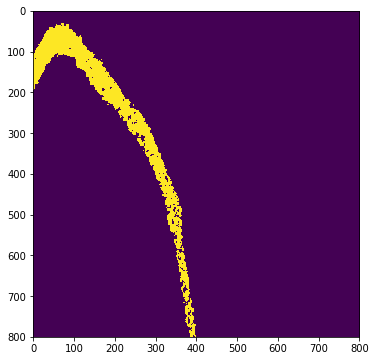

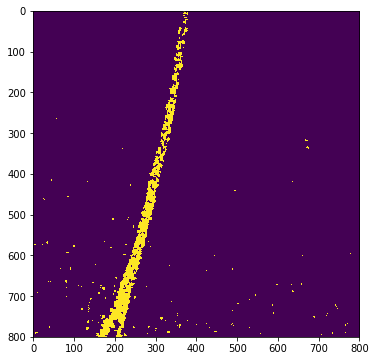

In [77]:
water_mask_multilook_improved = full_sigma0_image_multilook_improved>sigma0_seuil;

plot_binary(water_mask_multilook_improved)

for k in range(1,5): 
    plot_binary(np.abs(extract_zoom(k, water_mask_multilook_improved)))

Les bords haut et bas semblent s'être réhaussé en $\sigma_0$; en effet, les zones correspondant aux bords haut-droit, bas-gauche et haut démarquent mieux la Seine, en revanche, on a aussi amplifié la granularité sur le bas de l'image.
Ceci semble assez logique puisqu'on dégrade le coefficient multiplicatif lorsqu'on s'éloigne de l'angle médian $\theta_c$. 
Ainsi, le $\sigma_0$ est réhaussé en bas et en haut, ce qui pousse à faire apparaître la Seine là où le signal était plus faible, mais qui pousse également à créer des imperfections granulaires en bas de l'image, là où le $\sigma_0$ semblait déjà élevé en moyenne.